[View in Colaboratory](https://colab.research.google.com/github/abhinavrk/GoogleColabMusings/blob/master/char_rnn_classification_simplified.ipynb)

In [0]:
loaded = True

if not loaded:
  # http://pytorch.org/
  from os import path
  from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
  platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

  accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

  !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

  import torch

In [0]:
# !wget https://download.pytorch.org/tutorial/data.zip
# !unzip data.zip

In [0]:
%matplotlib inline

In [30]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

['data/names/Portuguese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Scottish.txt', 'data/names/Korean.txt', 'data/names/Dutch.txt', 'data/names/Czech.txt', 'data/names/Spanish.txt', 'data/names/Italian.txt', 'data/names/Greek.txt', 'data/names/Arabic.txt', 'data/names/Irish.txt', 'data/names/Japanese.txt', 'data/names/English.txt', 'data/names/Russian.txt', 'data/names/German.txt', 'data/names/Polish.txt', 'data/names/French.txt']
Slusarski


In [31]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])
torch.Size([5, 1, 57])


In [0]:
import torch.nn as nn

class RNN_linear(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_linear, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [0]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

In [0]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i


In [0]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [0]:
n_hidden = 128
rnn_linear = RNN_linear(n_letters, n_hidden, n_categories)
input = letterToTensor('A')
hidden =torch.zeros(1, n_hidden)

output, next_hidden = rnn_linear(input, hidden)

In [0]:
criterion = nn.NLLLoss()

In [0]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 7s) 3.9113 Varakuta / Japanese ✗ (Russian)
10000 10% (0m 15s) 0.5343 Nao / Chinese ✓
15000 15% (0m 22s) 0.7436 Bach / Vietnamese ✓
20000 20% (0m 29s) 3.8027 Cap / Korean ✗ (Czech)
25000 25% (0m 37s) 0.1506 Dang / Vietnamese ✓
30000 30% (0m 44s) 6.2769 Gravari / Italian ✗ (Greek)
35000 35% (0m 51s) 1.2522 Salvage / Greek ✗ (French)
40000 40% (0m 59s) 1.6529 Kim / Korean ✗ (Vietnamese)
45000 45% (1m 6s) 0.3528 Donoghue / Irish ✓
50000 50% (1m 13s) 0.8001 Nunes / Portuguese ✓
55000 55% (1m 21s) 1.4192 Jury / English ✓
60000 60% (1m 28s) 0.1377 Coilean / Irish ✓
65000 65% (1m 35s) 0.3763 Shinko / Japanese ✓
70000 70% (1m 43s) 1.2474 Bello / Italian ✗ (Spanish)
75000 75% (1m 50s) 1.1279 Tse / Chinese ✓
80000 80% (1m 57s) 2.0865 Grec / Polish ✗ (Spanish)


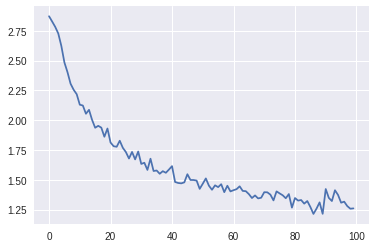

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)